# In-Class Exercise 10: Potentials and Sparse Matrices

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def Generiere_Rho(Nx=40, Ny=30, xRange=4e-9, yRange=3e-9):
    e = 1.6022e-19       # Elementarladung
    epsilon0 = 8.854e-12 # Vakuum Permittivität (Elektr. Feldkonstante) in As/Vm.
    Dimension = 2

    
    # Wir definieren zunächst leere Arrays for rho (Ladung) und Phi
    # (Potential), und dann auch die x- und y-Koordinaten für die Gridpunkte:
    rho = np.zeros((Ny,Nx))
    Phi = np.zeros((Ny,Nx))
    x1D = np.linspace(-xRange,xRange,Nx)
    y1D = np.linspace(-yRange,yRange,Ny)
    rmax = max(2*xRange,2*yRange)
    x,y = np.meshgrid(x1D,y1D)
    dx = x1D[2]-x1D[1]
    dy = y1D[2]-y1D[1]
    h2 = dx*dy;
    h = np.sqrt(h2);
    h3 = h**3;

    # Positionieren von 5 Ladungen:
    # An 35 Zufälligen Positionen positionieren wir nun ladungen von je einer
    # Elementarladung, aber mit zufälligem Vorzeichen. Dazu generieren wir uns zunächst
    # einen (5,1)-Vektor von zufälligen x- und y-Positionen:
    Nq = 5    # Anzahl der Ladungen
    Nrand = 5 # Mindestabstand vom Rand in Pixeln
    random.seed(4)   # macht die Zufallszahlen reproduzierbar
    # Generiere für jeden ZufallsPunkt eine zufälliges Ladungsvorzeichen:
    xq = np.zeros((Nq,1),dtype=int)
    yq = np.zeros((Nq,1),dtype=int)
    for iq in range(Nq): 
        xq[iq] = random.randint(Nrand,Nx-Nrand) 
        yq[iq] = random.randint(Nrand,Nx-Nrand)
        rho[yq[iq],xq[iq]] = -1+2*random.randint(0,1) # rho = +/-1

    # Generieren des Potentials
    # Wir wissen, dass jede der Punktladungen das Potential 
    # $$ V(r) = \frac{e}{4*\pi*\epsilon_0*|r|}$$
    # generiert. Das Gesamtpotential ist dann einfach die Superposition dieser
    # Punktladungen:
    for iq in range(Nq): 
        # Zunächst berechnen wir den Abstand jedes Pixels von der Ladung iq:
        ix = xq[iq] 
        iy = yq[iq]
        r = np.sqrt((x-x[iy,ix])**2+(y-y[iy,ix])**2)
        if Dimension == 3:
            rinv = (r**-1)/(4*np.pi)
        if Dimension == 2:
            rinv = np.log(rmax/r)/(2*np.pi*h)
        if Dimension == 1:
            rinv = 1/h2
        # Jetzt müssen wir noch den Wert von 1/(r=0) so definieren, dass die Zweite Ableitung 
        # dieser Funktion im Pixel links daneben gleich Null ist:
        rinv[iy,ix] = 4*rinv[iy,ix-1]-(rinv[iy+1,ix-1]+rinv[iy-1,ix-1]+rinv[iy,ix-2])
        Phi = Phi + rho[iy,ix]*e / epsilon0*rinv; 

    return rho,Phi,x,y

def surf(x,y,z):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(x*1e9, y*1e9, z,rstride=1,cstride = 1,cmap=plt.cm.CMRmap)
    plt.xlabel('x in nm')
    plt.ylabel('y in nm')

Jetzt können wir die Funktion GenerateRho() aufrufen und mit ihr eine Ladungsdichte, sowie ein mögliches, dieser Ladungsdichte korrespondierendes Potential generieren. 

D:\Software\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide


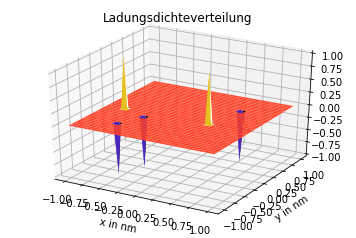

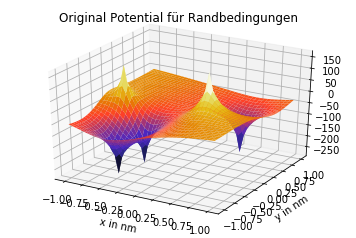

In [11]:
Nx = 40
Ny = 40
L = 1e-9
rho,Phi,x,y = Generiere_Rho(Nx, Ny, L, L)

surf(x,y,rho)
plt.title('Ladungsdichteverteilung')
surf(x,y,Phi)
plt.title('Original Potential für Randbedingungen')
plt.show()

# In-Class Task: Sparse Solver

Nachdem wir die Lösung mittel des Jacobi-Algorithmus für Laplace-Gleichung betrachtet haben, möchten wir nun die Poisson-Gleichung mit Dirichlet-Randbedingungen lösen (leichte Änderung der Gleichungen für die Ränder ergeben dann Neumann-Randbedingungen).

Hierfür generieren wir den $D-$Operator zunächst im List of Lists (lil) format, da es in diesem Format am effizientesten ist, neue Matrix-Elemente hinzuzufügen. Anschließens konvertieren wir diese Matrix in das Compressed Sparse Row (csr) format, um den (sparse) Lineare Gleichungen Löser aufrufen zu können.

In [12]:
import time
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

e = 1.6022e-19       # Elementarladung
epsilon0 = 8.854e-12 # Vakuum Permittivität (Elektr. Feldkonstante) in As/Vm.

Use scipy.sparse.lil_matrix to create an (Nx x Ny, Nx x Ny) matrix.

Create a Laplace operator, and use spsolve to solve the problem.

(Dirchlet boundary conditions - set to 1 on boundary; Neumann boundary conditions - set boundary to 1 and one-inside boundary to -1)

In [23]:
def sub2ind(array_shape, rows, cols):
    # Note that Python is 0-based indexing
    index = rows * array_shape[1] + cols
    return index

Text(0.5,0.92,'Potential aus Elementarpotentialen')

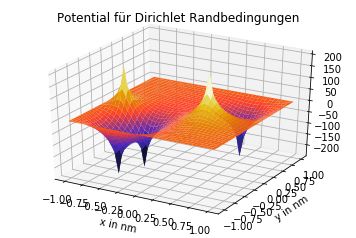

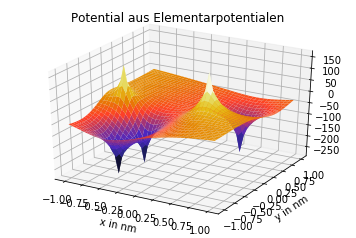

In [13]:
def Laplace_creat(Nx=30, Ny=30):
    
    N = Nx * Ny # Total number of points
    D = lil_matrix((N, N)) # Relationmatrix of these N points
    
    i_N = 0
    
    # Go through all the points except the boundaries
    for ix in np.arange(1, Nx-1):
        for iy in np.arange(1, Ny-1):
            D[i_N, sub2ind([Nx, Ny], ix, iy)] = 4
            D[i_N, sub2ind([Nx, Ny], ix+1, iy)] = -1
            D[i_N, sub2ind([Nx, Ny], ix-1, iy)] = -1
            D[i_N, sub2ind([Nx, Ny], ix, iy+1)] = -1
            D[i_N, sub2ind([Nx, Ny], ix, iy-1)] = -1
            
            
            
            
            i_N = i_N + 1
    
    # The Dirichlet-Boundary conditons
    for ix in np.arange(Nx):
        for iy in [0, Ny-1]: # First and last columns
            D[i_N, sub2ind([Nx, Ny], ix, iy)] = 1
            i_N = i_N + 1

    for iy in range(1,Ny-1):
        for ix in [0, Nx-1]: # First and last columns
            D[i_N, sub2ind([Nx, Ny], ix, iy)] = 1
            i_N = i_N + 1
    
    D = D.tocsr()
    return D

N = Nx * Ny
Nshort = (Ny-2)*(Nx-2)
h2 = (x[0,1]-x[0,0])*(y[1,0]-y[0,0])
h = np.sqrt(h2)
h3 = h**3

D = Laplace_creat(40, 40)
b = np.zeros((N,1))
b[0:Nshort] = np.reshape(rho[1:-1,1:-1],(Nshort,1))*h2*e/(h3*epsilon0)
Phi2 = np.reshape(spsolve(D, b),(Ny,Nx))





surf(x,y,Phi2)
plt.title('Potential für Dirichlet Randbedingungen')
surf(x,y,Phi)
plt.title('Potential aus Elementarpotentialen')